# Customer Lifetime Value

### In this notebook we'll be calculating customer lifetime value in an e-commerce setting, using PySpark. We'll go through the process step by step. Some of the data has been pre-computed for simplicity's sake.

In [1]:
import pandas as pd
import pyspark
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, IntegerType, StringType, StructType, StructField, FloatType
spark = SparkSession.builder.getOrCreate()

## 1. Import data. We import our Recency, Frequency, and Monetary values from the training set, and the dataframe of users who have shopped in the testing set. We also import a dataframe that gives the average spend of a shopper. Note that for the train-test split, we could use the train set as visitors to our site who have shopped in the first 6 months of the year, and the test set could be shoppers who have visited in the 2 months after that. 

## Note that R, F, M values have been calculated using K-means clustering. Recency is average number of days since last a user has last shopped, Frequency is the average number of times they visit in a period, and Monetary is the average spend per visit.

In [2]:
cluster_schema = StructType([ 
     StructField('user_id', DoubleType(), True),
    StructField('R', IntegerType(), True),
    StructField('F', IntegerType(), True),
    StructField('M', IntegerType(), True)
    ])

user_schema = StructType([ 
     StructField('user_id', DoubleType(), True)
    ])

spend_schema = StructType([ 
     StructField('user_id', DoubleType(), True),
     StructField('spend', DoubleType(), True)
    ])

# Load R,F,M data for shoppers in the train set
cluster_data = spark.read.load('/home/serena/workspace/Code/cluster_data.csv',format='csv', schema=cluster_schema)
cluster_data.createOrReplaceTempView("train")
# Load users who have purchased in the test set
user_data = spark.read.load('/home/serena/workspace/Code/forecast_data.csv',format='csv', schema=user_schema)
user_data.createOrReplaceTempView("test")
# Load avg spend (in the time period) of shoppers
spend_data = spark.read.load('/home/serena/workspace/Code/spend_data.csv',format='csv', schema=spend_schema)
spend_data.createOrReplaceTempView("spend")

## 2. Check if users who shopped in the training period also shopped in the test period. If so, label a new column "buy" with 1, if not, label "buy" with 0.

In [3]:
q = '''
    select DISTINCT A.*, 
       CASE WHEN B.user_id IS NOT NULL
       THEN 1
       ELSE 0
       END Buy
    from train A
    left join test B
    on A.user_id = B.user_id
'''
final_df = spark.sql(q)
final_df.createOrReplaceTempView("final_df")
final_df.show(5)

+---------------+---+---+---+---+
|        user_id|  R|  F|  M|Buy|
+---------------+---+---+---+---+
|4.0012107961E10|  3|  1|  0|  1|
|4.0139104351E10|  0|  0|  7|  1|
|4.0174106261E10|  5|  1|  6|  0|
|4.0200105444E10|  2|  1|  6|  1|
|4.0200120387E10|  7|  5|  2|  1|
+---------------+---+---+---+---+
only showing top 5 rows



## 3. For each cluster type, calculate the percentage of shoppers who repurchased in the test period. Plot percentage vs cluster values. This is done to see if there's a relationship between repurhcase rate and the R, F, M values. Depending on the results we'll use all variables, a pair, or just 1 to calculate retention rate.

In [4]:
# Get total number of shoppers
total_shoppers_q = '''
SELECT COUNT(*) FROM final_df
'''
spark.sql(total_shoppers_q).show()

+--------+
|count(1)|
+--------+
|    9397|
+--------+



In [5]:
R_df = spark.sql('''
SELECT ROUND(COUNT(*)/9397,4) as pct, R 
FROM final_df
WHERE Buy == 1
GROUP BY R
''')
F_df = spark.sql('''
SELECT ROUND(COUNT(*)/9397,4) as pct, F
FROM final_df
WHERE Buy == 1
GROUP BY F
''')
M_df = spark.sql('''
SELECT ROUND(COUNT(*)/9397,4) as pct, M
FROM final_df
WHERE Buy == 1
GROUP BY M
''')
# Let's look at what the M dataframe looks like
M_df.show(5)

+------+---+
|   pct|  M|
+------+---+
|0.0548|  1|
|0.1817|  6|
|0.0229|  3|
|0.0076|  5|
|0.0013|  9|
+------+---+
only showing top 5 rows



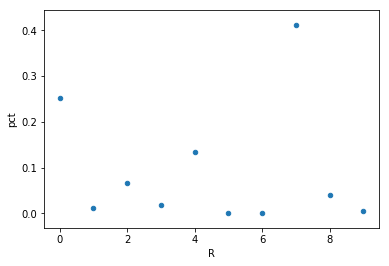

In [6]:
# Convert to pandas for plotting sake
R_df.toPandas().plot(x="R", y="pct", kind='scatter')

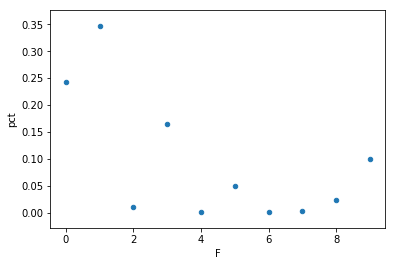

In [7]:
# Convert to pandas for plotting sake
F_df.toPandas().plot(x="F", y="pct", kind='scatter')

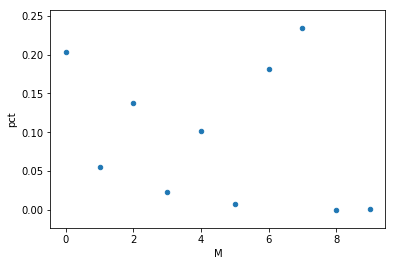

In [8]:
# Convert to pandas for plotting sake
M_df.toPandas().plot(x="M", y="pct", kind='scatter')

## Ok, so this looks pretty bad. The data sample wasn't good. Well, let's continue on pretending that there was a clear relationship between R, F, M and retention rate.
## 4. Build a simple churn prediction model to estimate repurchase rate for each user. We'll use logistic regression for our model, with R, F, M values as our features.

In [9]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.pipeline import Pipeline

# Data
data = final_df.withColumnRenamed("Buy", "label")
training_set, testing_set = data.randomSplit([0.75,0.25])

# Model and pipeline
lr = LogisticRegression()
assembler = VectorAssembler(inputCols = ["R","F","M"], outputCol="features")
pipeline = Pipeline(stages=[assembler,lr])

# Fit the pipeline
fitted_pipeline = pipeline.fit(training_set)

# Get model from the fitted pipeline
lrModel = fitted_pipeline.stages[-1]

## 5. Using the trained model, use the predict function on the training data. We aren't looking to actually predict anything, we just want to get what their estimated retention rate (or churn prediction) is according to the model.

## Note that the "probability" value is the shopper's predicted retention rate

In [10]:
# Get predictions from the model
# The probability value is their retention rate
predictions = lrModel.transform(assembler.transform(testing_set)).select("user_id", "probability")
predictions.show(5)

+---------------+--------------------+
|        user_id|         probability|
+---------------+--------------------+
|4.0139104351E10|[0.05226305281064...|
|4.0200170448E10|[0.03050619244610...|
|4.0200171381E10|[0.06559904646208...|
|4.0200570292E10|[0.10562249716665...|
|4.0201289392E10|[0.05090490142665...|
+---------------+--------------------+
only showing top 5 rows



## 6. Get retention rate for each user: this requires a bit of tricky PySpark code

In [11]:
secondelement=udf(lambda v:float(v[1]),FloatType())
predictions = (predictions.select(secondelement('probability'), "user_id")
        .withColumnRenamed("<lambda>(probability)", "retention_rate"))
predictions.show(5)

+--------------+---------------+
|retention_rate|        user_id|
+--------------+---------------+
|     0.9477369|4.0139104351E10|
|     0.9694938|4.0200170448E10|
|      0.934401|4.0200171381E10|
|     0.8943775|4.0200570292E10|
|     0.9490951|4.0201289392E10|
+--------------+---------------+
only showing top 5 rows



## 7. Join the retention rate data to the average spend data, so that we have a table with the user's average spend and retention rate. This is what we need to calculate customer lifetime value.

In [12]:
data = predictions.join(spend_data, how="inner", on ="user_id")
data.show(5)

+---------------+--------------+------------------+
|        user_id|retention_rate|             spend|
+---------------+--------------+------------------+
|4.0139104351E10|     0.9477369| 766.3600000000008|
|4.0200170448E10|     0.9694938|6255.0099999999275|
|4.0200171381E10|      0.934401|  908.550000000001|
|4.0200570292E10|     0.8943775|             193.5|
|4.0201289392E10|     0.9490951|1534.0700000000006|
+---------------+--------------+------------------+
only showing top 5 rows



## 8. Define our CLV equation

In [13]:
def calc_clv(df, num_periods, discount):

    clv = lambda num_periods, retention, spend, discount: sum(
        [spend*(retention/(1 + discount))**t for t in range(1, num_periods + 1)])
    clv_rdd = (df.rdd.map(lambda x: (x["user_id"],
                                     round(clv(num_periods, x["retention_rate"],
                                           x["spend"], discount), 2))))

    clv_df = clv_rdd.toDF().withColumnRenamed("_1", "user_id").withColumnRenamed("_2", "CLV")

    return clv_df

## 9. Apply our CLV equation: let's use a lifetime of 10 periods, and a discount rate of 0.1.

In [14]:
lifetime = 10
discount = 0.1
clv_df = calc_clv(data, 10, 0.1) 
clv_df.show(5)

+---------------+--------+
|        user_id|     CLV|
+---------------+--------+
|4.0139104351E10| 3694.91|
|4.0200170448E10|33324.59|
|4.0200171381E10|  4123.7|
|4.0200570292E10|  735.38|
|4.0201289392E10| 7442.23|
+---------------+--------+
only showing top 5 rows



## And there you have it! Customer lifetime value calculation = complete! 
#### Now to figure out how useful it is...